# Random Forest

- Random Forest is combination of many decision trees
- It is a classification algorithm.

Why do we need Random Forest over Decision Trees?
- Though Decision Trees are easy to build, use and interpret, but they are inaccurate
- DTs are not very good with unseen data so our Model may not work as desired
- Random Forest = Simplicity of DT + Very Good Accuracy

## Input

1. .csv - produced by pre_processing.ipynb
2. The pre_processed input data includes following techniques:
   * MinMax Scaling
   * PCA
   * Correlation

## Output/Analysis

1. Visualising the accuracy of RF with k-fold validation.
2. Comparing the accuracy of RF model with and without PCA.   

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 
import seaborn as sns
acc = []
f1 =  []
acc1 = []
f11 =  []
df = pd.DataFrame()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')     #uncomment only if working with google colab

Mounted at /content/drive


In [ ]:
def load_data(filename):
    return pd.read_csv(filename)

# Spilt the input file into test and train dataset

I/P: dataframe

O/P: x_cross_val, y_cross_val, x_test, y_test

In [ ]:
def prep_training(network_data):
    return train_test_split(network_data, train_size=0.8, test_size=0.2, random_state=42)

# Hyperparameter Tuning for Random Forest

The following hyperparamter tuning has taken reference from:
1. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
2. https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead

In [ ]:
from pprint import pprint

Instead of all the above the parameters, we will just focus on tuning a few as given below:
We will try adjusting a few of the following set of hyperparameters:
1. n_estimators = number of trees in the foreset
2. max_features = max number of features considered for splitting a node
3. max_depth = max number of levels in each decision tree
4. min_samples_split = min number of data points placed in a node before the node is split
5. min_samples_leaf = min number of data points allowed in a leaf node
6. bootstrap = method for sampling data points (with or without replacement)

To use CV, we first need to create a parameter grid to sample from during fitting:

Params From reference github
- n_estimators=[30,60,90,120]  
- max_features = Not included
- max_depth = [10,15,20]
- min_samples_split = [2,4,6]
- min_samples_leaf = not included
- bootstrap = not included


### RandomizedSearch CV versus GridSearchCV

Grid Search is good when we work with a small number of hyperparameters. However, if the number of parameters to consider is particularly high and the magnitudes of influence are imbalanced, the better choice is to use the Random Search. [Reference](https://towardsdatascience.com/machine-learning-gridsearchcv-randomizedsearchcv-d36b89231b10)

Therefore, we have used GridSearchCV.

In [ ]:
def creatingParamterGrid():
    n_estimators = [30,60,90,120]   # Number of trees in random forest
    max_depth = [10,15,20]    # Maximum number of levels in tree
    min_samples_split = [2,4,6]  # Minimum number of samples required to split a node
    
    # Create the parameter grid
    parameter_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
    return parameter_grid

## Cross-Validated Grid Search

We are now ready to create our grid-search object. We'll use each of the objects we've created thus far.
Instead of passing a `PredefinedSplit` object tothe `cv` paramter, we are simply passing the number of folds.

In [ ]:
def prepToFindOptimalHyperParams(clf,parameter_grid):
    grid_search = GridSearchCV(estimator=clf, cv=3, param_grid = parameter_grid)
    return grid_search

## Training the Model

Now that we have created our `grid_search` object, we are ready to train our model.

In [ ]:
def train(cross_val_df,grid_search):
    grid_search.fit(cross_val_df.drop("label",axis=1), cross_val_df["label"])
    Xpred = grid_search.predict(cross_val_df.drop("label",axis=1))
    print("accuracy on train is",accuracy_score(cross_val_df["label"],Xpred))

We are training models = (Number of unique Hyperparamter Combinations * number of folds) + 1

## Cross-validated Results

To examine the results individual fold, we use `grid_search`'s `cv_results_` attribute.
pd.DataFrame(grid_search.cv_results_).head()

## Optimal Hyperparamters

grid_search.best_params_
grid_search.best_score_

# Test the model and analyse it

In [ ]:
def testRandomForestModel(test_df,grid_search,type):
    Ytest = test_df["label"]
    Ypred = grid_search.predict(test_df.drop("label",axis=1))
    print(classification_report(Ytest,Ypred))   
    acc1.append(accuracy_score(Ytest,Ypred))
    acc=accuracy_score(Ytest,Ypred)
    print('Accuracy of Random Forest:',(acc)) 
    f1.append(f1_score(Ytest,Ypred))
    plt.savefig('confusion_matrix'+type+'.jpg')
    cm = confusion_matrix(Ytest, Ypred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax) 
    print(cm)
    return acc1


# Main Function

In [ ]:
def main(network_data,type): 
    clf = RandomForestClassifier(random_state=42)
    cross_val_df, test_df = prep_training(network_data)
    parameter_grid = creatingParamterGrid()
    pprint(parameter_grid)
    grid_search = prepToFindOptimalHyperParams(clf,parameter_grid)
    train(cross_val_df,grid_search)
    acc1=testRandomForestModel(test_df,grid_search,type)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search,acc1

# Classification with RF without preprocessing

In [ ]:
network_data = load_data('https://raw.githubusercontent.com/divyaKh/CMPE255Project/main/2.Data_Cleaning/cleaned_dataset_label_encoding.csv')

{'max_depth': [10, 15, 20],
 'min_samples_split': [2, 4, 6],
 'n_estimators': [30, 60, 90, 120]}
accuracy on train is 0.9759675557151035
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18675
           1       0.96      0.96      0.96     32860

    accuracy                           0.95     51535
   macro avg       0.94      0.95      0.94     51535
weighted avg       0.95      0.95      0.95     51535

Accuracy of Random Forest: 0.9487920830503541
[[17508  1167]
 [ 1472 31388]]
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 60}
0.9476564252995031


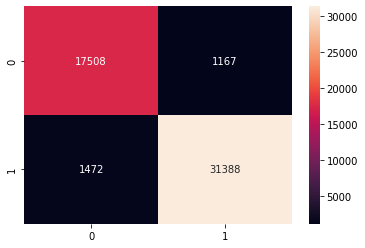

In [ ]:
network_data = network_data.drop("attack_cat",axis=1)

grid_search,acc1 = main(network_data,'withoutpreprocess')

In [ ]:

df['Accuracy_without_pp'] =acc1
df['F1_score_without_pp']=f1


In [ ]:
df

,Accuracy_without_pp,F1_score_without_pp
0,0.948792,0.959658


# Classification with RF after MinMax Scaling 

In [ ]:
network_data1 = load_data('../input/dataset_minmax.csv')

In [ ]:
network_data1

,# dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1.833334e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000033,0.000000,0.090909,0.996078,0.000000,0.030121,0.000000,0.000000,0.000000,1.303758e-07,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.151351,0.000000,0.0,0.0,0.016129,0.333333,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0,0
1,1.333334e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000121,0.000000,0.125000,0.996078,0.000000,0.147128,0.000000,0.000000,0.000000,9.481875e-08,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.579054,0.000000,0.0,0.0,0.016129,0.333333,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0,0
2,8.333335e-08,0.901515,0.000000,0.5,0.000094,0.000000,0.000073,0.000000,0.200000,0.996078,0.000000,0.142685,0.000000,0.000000,0.000000,5.926172e-08,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.344595,0.000000,0.0,0.0,0.032258,0.333333,0.000000,0.000000,0.000000,0.031250,0.0,0.0,0.0,0.000000,0.032787,0.0,0
3,1.000000e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000061,0.000000,0.166667,0.996078,0.000000,0.100200,0.000000,0.000000,0.000000,7.111406e-08,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.287838,0.000000,0.0,0.0,0.032258,0.333333,0.017241,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0,0
4,1.666667e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000146,0.000000,0.100000,0.996078,0.000000,0.142017,0.000000,0.000000,0.000000,1.185234e-07,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.702027,0.000000,0.0,0.0,0.032258,0.333333,0.017241,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.008461,0.000000,0.000000,0.000000,1.066711e-07,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.370968,0.333333,0.396552,0.396552,0.266667,0.359375,0.0,0.0,0.0,0.389831,0.377049,0.0,1
257669,8.429368e-03,0.856061,0.000000,0.4,0.000845,0.000726,0.000042,0.000024,0.000034,0.996078,0.992126,0.000001,0.000219,0.000376,0.000182,6.447688e-04,0.00116,0.002508,0.000259,1.0,0.819281,0.804002,1.0,0.026021,0.011434,0.021355,0.025676,0.029333,0.0,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.000000,0.0,1
257670,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.008461,0.000000,0.000000,0.000000,1.066711e-07,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.177419,0.333333,0.034483,0.034483,0.044444,0.187500,0.0,0.0,0.0,0.033898,0.180328,0.0,1
257671,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,0.000000,0.008461,0.000000,0.000000,0.000000,1.066711e-07,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,0.0,0.467742,0.333333,0.500000,0.500000,0.288889,0.453125,0.0,0.0,0.0,0.491525,0.475410,0.0,1


{'max_depth': [10, 15, 20],
 'min_samples_split': [2, 4, 6],
 'n_estimators': [30, 60, 90, 120]}
accuracy on train is 0.9755406572296229
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     18675
           1       0.96      0.96      0.96     32860

    accuracy                           0.95     51535
   macro avg       0.94      0.95      0.95     51535
weighted avg       0.95      0.95      0.95     51535

Accuracy of Random Forest: 0.9495100417192199
[[17480  1195]
 [ 1407 31453]]
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 90}
0.9479474904012962


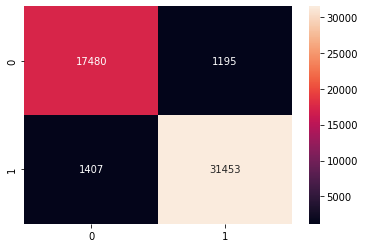

In [ ]:
grid_search1,acc1= main(network_data1,'minmax')

In [ ]:
pd.DataFrame(grid_search1.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.136547,0.043206,0.273924,0.004853,10,2,30,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.934146,0.936111,0.934597,0.934951,0.000840,36
1,10.496857,0.100036,0.529742,0.010675,10,2,60,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.934976,0.936155,0.934844,0.935325,0.000589,31
2,15.614794,0.078824,0.777811,0.010284,10,2,90,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.934990,0.936140,0.935266,0.935466,0.000490,27
3,20.857192,0.061969,1.022703,0.013535,10,2,120,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.934743,0.936140,0.935033,0.935305,0.000602,32
4,5.207337,0.126309,0.267879,0.004343,10,4,30,"{'max_depth': 10, 'min_samples_split': 4, 'n_e...",0.933884,0.936140,0.935295,0.935107,0.000931,35


Here:
1. {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 90} = best params after hyperparameter tuning
2. 0.9479474904012962 is the best score after Cross Validation of Random Forest.

In [ ]:
df['Accuracy_rf_mm'] =acc1[1]
df['F1_score1_rf_mm']=f1[1]

In [ ]:
df

,Accuracy_without_pp,F1_score_without_pp,Accuracy_rf_mm,F1_score1_rf_mm
0,0.948792,0.959658,0.94951,0.96028


# Classification with RF after MinMax Scaling + Correlation analysis

In [ ]:
network_data2 = load_data('../input/dataset_minmax_corr.csv')

{'max_depth': [10, 15, 20],
 'min_samples_split': [2, 4, 6],
 'n_estimators': [30, 60, 90, 120]}
accuracy on train is 0.9697532720798688
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     18675
           1       0.95      0.95      0.95     32860

    accuracy                           0.94     51535
   macro avg       0.94      0.94      0.94     51535
weighted avg       0.94      0.94      0.94     51535

Accuracy of Random Forest: 0.9400795575822257
[[17117  1558]
 [ 1530 31330]]
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 120}
0.9383422787135555


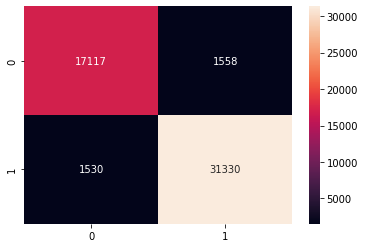

In [ ]:
grid_search2,acc1 = main(network_data2,'minmax_corr')

In [ ]:
pd.DataFrame(grid_search2.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.761280,0.022305,0.220953,0.009985,10,2,30,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.923144,0.921063,0.920771,0.921659,0.001057,35
1,9.422334,0.121709,0.431777,0.004233,10,2,60,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.923115,0.922606,0.921266,0.922329,0.000780,30
2,14.284051,0.125072,0.633435,0.016495,10,2,90,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.923115,0.921572,0.921207,0.921965,0.000827,32
3,18.780188,0.094465,0.847156,0.014602,10,2,120,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.923464,0.922416,0.921149,0.922343,0.000947,29
4,4.701138,0.092969,0.218946,0.004928,10,4,30,"{'max_depth': 10, 'min_samples_split': 4, 'n_e...",0.921267,0.923915,0.922590,0.922591,0.001081,27


In [ ]:
df['Accuracy2_rf_mm_corr'] =acc1[2]
df['F1_score2_rf_mm_corr']=f1[2]

In [ ]:
df

,Accuracy_without_pp,F1_score_without_pp,Accuracy_rf_mm,F1_score1_rf_mm,Accuracy2_rf_mm_corr,F1_score2_rf_mm_corr
0,0.948792,0.959658,0.94951,0.96028,0.94008,0.953033


# Classification with RF after Dimension Reduction (using PCA)

In [ ]:
network_data3 = load_data('../input/dataset_pca.csv')

{'max_depth': [10, 15, 20],
 'min_samples_split': [2, 4, 6],
 'n_estimators': [30, 60, 90, 120]}
accuracy on train is 0.9840204135093966
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     18675
           1       0.94      0.96      0.95     32860

    accuracy                           0.93     51535
   macro avg       0.93      0.92      0.92     51535
weighted avg       0.93      0.93      0.93     51535

Accuracy of Random Forest: 0.9295624332977588
[[16506  2169]
 [ 1461 31399]]
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 90}
0.927892964597675


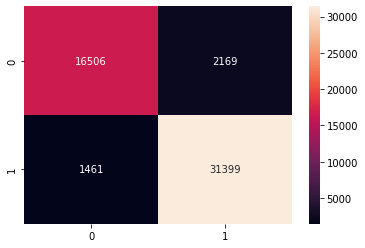

In [ ]:
grid_search3,acc1 = main(network_data3,'pca')

In [ ]:
pd.DataFrame(grid_search3.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,15.659091,0.102826,0.240117,0.008933,10,2,30,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.909391,0.909449,0.909346,0.909396,0.000042,32
1,31.345804,0.146834,0.467747,0.024043,10,2,60,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.910410,0.910410,0.910743,0.910521,0.000157,25
2,47.310032,0.373412,0.709879,0.001633,10,2,90,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.910512,0.909653,0.910903,0.910356,0.000522,26
3,63.256934,0.376674,0.930941,0.015928,10,2,120,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.910308,0.909464,0.910671,0.910148,0.000506,27
4,15.705550,0.195856,0.234080,0.003478,10,4,30,"{'max_depth': 10, 'min_samples_split': 4, 'n_e...",0.908460,0.910192,0.908371,0.909008,0.000838,35


In [ ]:
df['Accuracy2_rf_pca'] =acc1[3]
df['F1_score2_rf_pca']=f1[3]

In [ ]:
df

,Accuracy_without_pp,F1_score_without_pp,Accuracy_rf_mm,F1_score1_rf_mm,Accuracy2_rf_mm_corr,F1_score2_rf_mm_corr,Accuracy2_rf_pca,F1_score2_rf_pca
0,0.948792,0.959658,0.94951,0.96028,0.94008,0.953033,0.929562,0.945354


In [ ]:
def displayAnalysisGraphs(list1, acc,f1,model):
  plt.scatter(list1,acc)
  for i in range(len(list1)):
    acc[i]=float('{:,.3f}'.format(acc[i]))
    plt.annotate(str(acc[i]), xy=(list1[i], acc[i]))
  plt.ylabel("Accuracy")
  plt.title("Accuracy for dataset after different preprocessing techniques for "+model)
  plt.savefig("Accuracy"+model+".png")
  plt.show()
  plt.scatter(list1,f1)
  for i in range(len(list1)):
    f1[i]=float('{:,.3f}'.format(f1[i]))
    plt.annotate(str(f1[i]), xy=(list1[i], f1[i]))
  plt.ylabel("F1 score")
  plt.title("F1 scores for dataset after different preprocessing techniques for "+model)
  plt.savefig("F1_scores"+model+".png")
  plt.show()

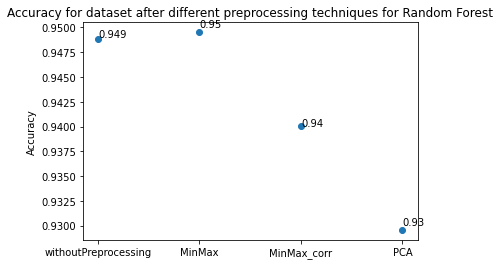

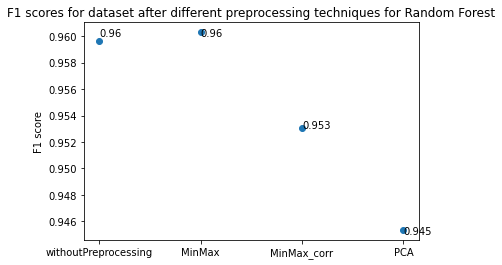

In [ ]:
list1 = ['withoutPreprocessing','MinMax','MinMax_corr','PCA']
displayAnalysisGraphs(list1,acc1,f1,"Random Forest")

In [ ]:
df.to_csv("Random_forest_result.csv")